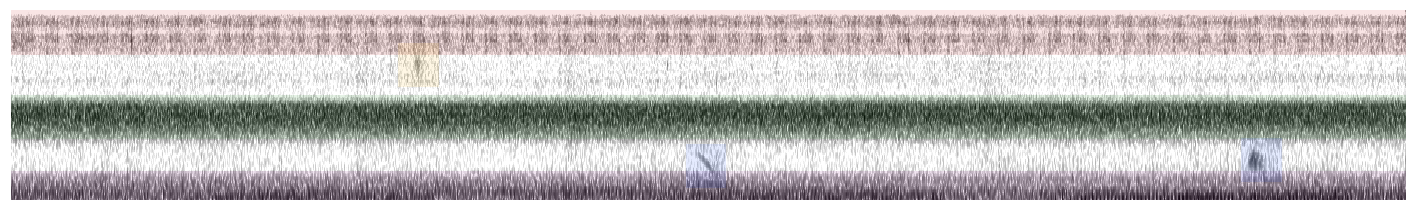

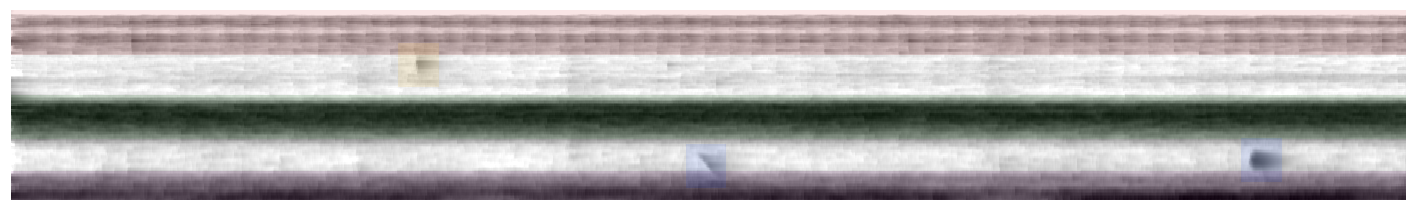

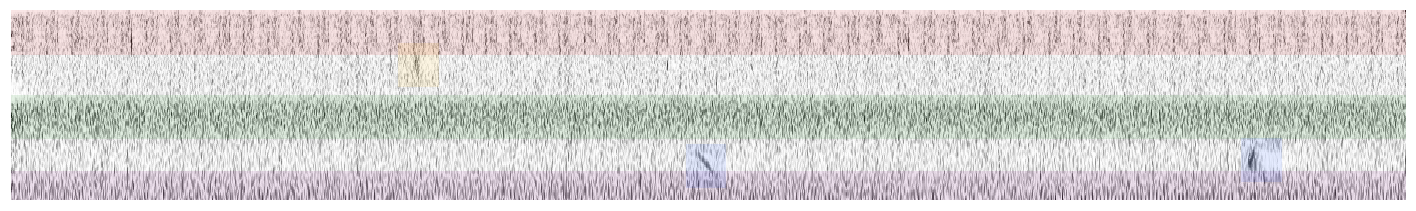

In [10]:
import sys
sys.path.append("../src")
import localmodule

import h5py
import librosa
import numpy as np
import os
import pandas as pd
import soundfile as sf

# Define PCEN smoother.
def pcen_smooth(melspec, time_constant_frames):
    smoothed_melspec = melspec.copy()
    coeff = 1.0 / time_constant_frames
    num_cols = melspec.shape[1]
    for col in np.arange(1, num_cols):
        smoothed_melspec[:, col] =\
            smoothed_melspec[:, col - 1] +\
            (melspec[:, col] - smoothed_melspec[:, col - 1]) * coeff
    return smoothed_melspec

unit_str = "unit02"
center_hour = 0
center_minute = 52
center_second = 39.3
snippet_duration = 10 # in s

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
full_audio_str = "_".join([dataset_name, "full-audio"])
full_audio_dir = os.path.join(data_dir, full_audio_str)
models_dir = localmodule.get_models_dir()
model_name = "pcen-add-convnet_aug-all-but-noise"
model_dir = os.path.join(models_dir, model_name)
unit_dir = os.path.join(model_dir, unit_str)

recording_str = unit_str + ".flac"
recording_path = os.path.join(full_audio_dir, recording_str)
full_audio = sf.SoundFile(recording_path)
full_audio_length = len(full_audio)

center_timestamp = 3600 * center_hour + 60 * center_minute + center_second
begin_timestamp = center_timestamp - snippet_duration / 2
sample_rate = localmodule.get_sample_rate()
begin_sample = int(begin_timestamp * sample_rate)
full_audio.seek(begin_sample)
chunk_waveform = full_audio.read(snippet_duration * sample_rate)

logmelspec_settings = localmodule.get_logmelspec_settings()
pcen_settings = localmodule.get_pcen_settings()
chunk_waveform = librosa.resample(
    chunk_waveform, sample_rate, logmelspec_settings["sr"])
chunk_waveform = chunk_waveform * (2**32)

stft = librosa.stft(
    chunk_waveform,
    n_fft=logmelspec_settings["n_fft"],
    win_length=logmelspec_settings["win_length"],
    hop_length=logmelspec_settings["hop_length"],
    window=logmelspec_settings["window"])

# Delete last sample to compensate for padding.
stft = stft[:, :-1]

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
melspec = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=logmelspec_settings["sr"],
    n_fft=logmelspec_settings["n_fft"],
    n_mels=logmelspec_settings["n_mels"],
    htk=True,
    fmin=logmelspec_settings["fmin"],
    fmax=logmelspec_settings["fmax"])
n_hops = melspec.shape[1]

# Smooth in time.
smoothed_melspec =\
    pcen_smooth(melspec, pcen_settings["pcen_time_constant_frames"])
    
pcen_gain = (smoothed_melspec + 1) ** pcen_settings["pcen_norm_exponent"]
pcen_melspec = melspec * pcen_gain

# Raise to PCEN exponent.
pcen_offset = pcen_melspec.max() / 10.0
pcen =\
    (pcen_melspec + pcen_offset) ** pcen_settings["pcen_power"] -\
    pcen_offset ** pcen_settings["pcen_power"]
    

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from librosa.display import specshow

min_db = 132

annotations_name = "_".join([dataset_name, "annotations"])
annotations_dir = os.path.join(data_dir, annotations_name)
annotation_name = unit_str + ".txt"
annotation_path = os.path.join(annotations_dir, annotation_name)
annotation = pd.read_csv(annotation_path, '\t')
begin_times = annotation["Begin Time (s)"]
annotation = annotation[np.abs(begin_times - center_timestamp) < (snippet_duration / 2)]
mel_frequencies = librosa.mel_frequencies(
    fmin = pcen_settings["fmin"],
    fmax = pcen_settings["fmax"],
    n_mels = pcen_settings["n_mels"])


# ANNOTATIONS
from matplotlib.patches import Rectangle
def get_rects():
    alpha = 0.1
    rects = [
        Rectangle((0, 98), n_hops, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#CB0003'),
        Rectangle((0, 41), n_hops, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#008000'),
        Rectangle((0, 0),  n_hops, 20, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#80007F'),
        Rectangle((1915, 76), 200, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#FFB800'),
        Rectangle((3335, 8),  200, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#0040FF'),
        Rectangle((6079, 12), 200, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#0040FF')
    ]
    return rects

    
# MEL SPECTROGRAM
plt.figure(figsize=(25, 3.5))
logmelspec = librosa.logamplitude(melspec)
logmelspec = np.maximum(logmelspec, min_db)
specshow(logmelspec, cmap="gray_r")
for rect in get_rects():
    plt.gca().add_patch(rect)
plt.axis('off');
plt.savefig("spl_diagram_melspec.png", bbox_inches='tight')


# SMOOTHED MEL SPECTROGRAM
plt.figure(figsize=(25, 3.5))
smoothed_logmelspec = librosa.logamplitude(smoothed_melspec)
smoothed_logmelspec = np.maximum(smoothed_logmelspec, min_db)
specshow(smoothed_logmelspec, cmap="gray_r")
for rect in get_rects():
    plt.gca().add_patch(rect)
plt.axis('off');
plt.savefig("spl_diagram_avg-melspec.png", bbox_inches='tight')


# PCEN
plt.figure(figsize=(25, 3.5))
log_pcen = np.log1p(pcen / 2)
specshow(log_pcen, cmap="gray_r")
for rect in get_rects():
    plt.gca().add_patch(rect)
plt.axis('off');
plt.savefig("spl_diagram_pcen.png", bbox_inches='tight')


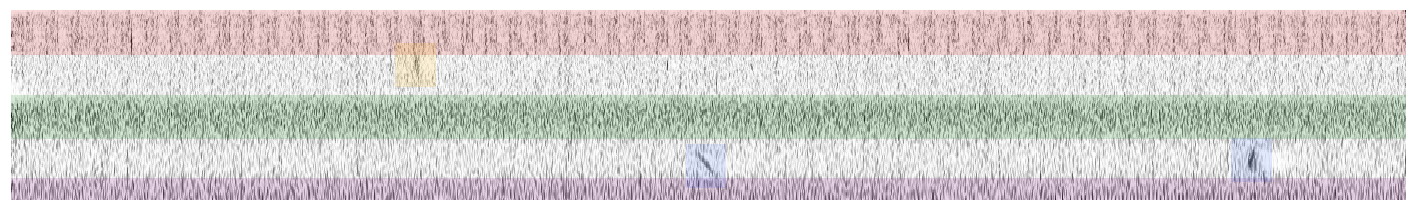

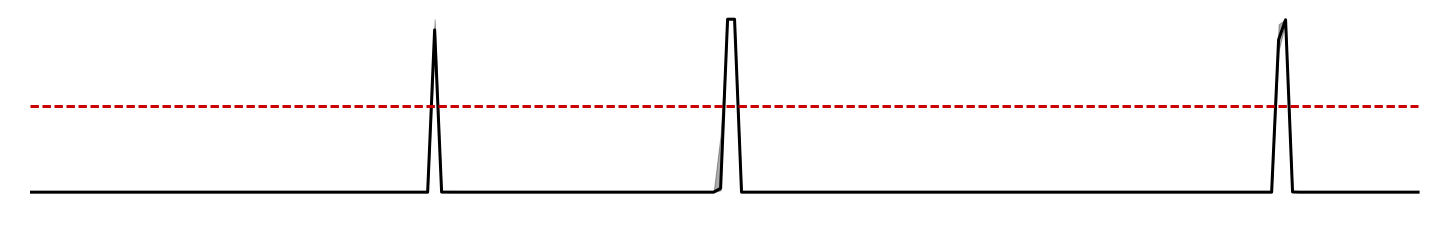

In [12]:

# DETECTION FUNCTIONS
n_best_trials = 6
edf_snippets = []
edf_thresholds = []
edf_f1_scores = []
for trial_id in range(10):
    trial_str = "trial-" + str(trial_id)
    trial_dir = os.path.join(unit_dir, trial_str)
    metrics_name = "_".join([
        dataset_name,
        model_name,
        "test-" + unit_str,
        trial_str,
        "predict-" + unit_str,
        "full-audio-metrics.csv"])
    metrics_path = os.path.join(trial_dir, metrics_name)
    # We take the oracle threshold for the visualization
    f1_scores = pd.read_csv(metrics_path)["F1 Score (%)"]
    threshold_id = np.argmax(f1_scores)
    edf_f1_scores.append(f1_scores[threshold_id])
    thresholds = pd.read_csv(metrics_path)["Threshold"]
    edf_threshold = thresholds[threshold_id]
    predictions_name = "_".join([
        dataset_name,
        model_name,
        "test-" + unit_str,
        trial_str,
        "predict-" + unit_str,
        "full-predictions.csv"])
    predictions_path = os.path.join(trial_dir, predictions_name)
    edf_start_id = np.argmin(np.abs(np.array(
        pd.read_csv(predictions_path)["Timestamp"]) - begin_timestamp))
    stop_timestamp = begin_timestamp + snippet_duration
    edf_stop_id = np.argmin(np.abs(np.array(
        pd.read_csv(predictions_path)["Timestamp"]) - stop_timestamp))
    edf = pd.read_csv(predictions_path)["Predicted probability"]
    edf_start_id = np.argmin(np.abs(np.array(
        pd.read_csv(predictions_path)["Timestamp"]) - begin_timestamp))
    edf_stop_id = edf_start_id + 200
    edf_snippet = np.array(edf[edf_start_id:edf_stop_id])
    edf_snippet = 1 / (2 - edf_threshold - edf_snippet)
    edf_threshold = 1 / (2 - 2 * edf_threshold) * np.ones(edf_snippet.shape)
    edf_snippets.append(edf_snippet)
    edf_thresholds.append(edf_threshold)
edf_f1_scores = np.array(edf_f1_scores)
sorted_trials = np.argsort(edf_f1_scores)[::-1]
edf_snippets = np.stack(edf_snippets).T
edf_thresholds = np.stack(edf_thresholds).T
edf_ratios = 0.5 *\
    edf_snippets[:, sorted_trials[:n_best_trials]] /\
    edf_thresholds[:, sorted_trials[:n_best_trials]]
edf_sorted_ratios = np.sort(edf_ratios, axis=1)  
edf_median = np.median(edf_sorted_ratios, axis=1)
edf_quartiles = np.percentile(edf_sorted_ratios, [25, 75], axis=1)
edf_extremes = np.percentile(edf_sorted_ratios, [0, 100], axis=1)
plt.figure(figsize=(25, 3.5))
plt.plot(edf_median, linewidth=3.0, color="#000000")
plt.fill_between(range(edf_median.shape[0]),
                 edf_quartiles[0], edf_quartiles[1],
                 color="#000000", alpha=0.33)
plt.plot(0.5 * np.ones(edf_median.shape), '--', color = '#CB0003', linewidth=3.0)
plt.xlim([0, edf_sorted_ratios.shape[0]]);
plt.axis('off');
plt.savefig("spl_diagram_detection-function.png", bbox_inches='tight')

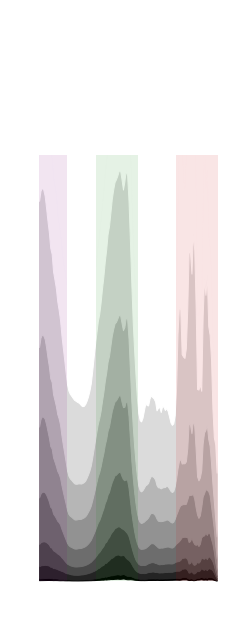

In [50]:
# AUXILIARY FEATURES
# Get auxiliary features
backgrounds_name = "_".join(
    [dataset_name, "full-pcen-backgrounds"])
backgrounds_dir = os.path.join(data_dir, backgrounds_name)
T_name = "T-1800"
T_dir = os.path.join(backgrounds_dir, T_name)
background_name = "_".join([
    dataset_name,
    "pcen-backgrounds",
    unit_str,
    "T-1800.hdf5"
])
background_path = os.path.join(T_dir, background_name)
background_file = h5py.File(background_path)
background_dataset = background_file["pcen_background"]
background_id = int(np.round(
    background_dataset.shape[2] * center_timestamp * sample_rate / len(full_audio)))
auxiliary_features = background_dataset[:, :, background_id]

plt.figure(figsize=(3.5, 11))
auxiliary_features = (auxiliary_features.T);
n_auxiliary_features = auxiliary_features.shape[1];
freq_range = list(range(logmelspec_settings["n_mels"]))
for aux_id in range(n_auxiliary_features-1):
    color_id = int(np.linspace(0, 256, n_auxiliary_features-1)[aux_id])
    plt.fill_between(freq_range, 
        auxiliary_features[:, aux_id], auxiliary_features[:, 1+aux_id],
        color=matplotlib.cm.gray(color_id));
plt.gca().add_patch(Rectangle((98,0), 30, 3.2, linewidth=10, edgecolor='none', alpha = 0.1, facecolor='#CB0003'))
plt.gca().add_patch(Rectangle((41,0), 30, 3.2, linewidth=10, edgecolor='none', alpha = 0.1, facecolor='#008000'))
plt.gca().add_patch(Rectangle((0, 0), 20, 3.2, linewidth=10, edgecolor='none', alpha = 0.1, facecolor='#80007F'))
    

#Rectangle((0, 41), n_hops, 30, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#008000')
#Rectangle((0, 0),  n_hops, 20, linewidth=10, edgecolor='none', alpha = alpha, facecolor='#80007F')
plt.axis('off');
plt.savefig("spl_diagram_aux-features.png", bbox_inches='tight')



In [34]:
rect.get_

In [35]:
rect

In [29]:
for id, row in annotation.iterrows():
    center_time = 0.5 * (row["End Time (s)"] + row["Begin Time (s)"])
    relative_time = center_time - center_timestamp
    center_freq = 0.5 * (row["Low Freq (Hz)"] + row["High Freq (Hz)"])
    mel_id = np.argmin(np.abs(center_freq - mel_frequencies))
    n_hops = logmelspec.shape[1]
    relative_hop_id = relative_time * (n_hops / snippet_duration)
    hop_id = int(0.5 * n_hops + relative_hop_id)
    print(center_freq)
    #plt.plot(hop_id, mel_id, "o", color="#0040FF", markersize=10.0)
    

8042.6
3829.8
4595.7
